In [102]:
import pandas as pd 
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torch.utils.data as data_utils
import itertools
from sklearn.metrics import confusion_matrix

path = "/datasets/home/73/673/h6gupta/Challenge/challenge_dataset.csv"
data = pd.read_csv(path, header = None)
data = data.convert_objects(convert_numeric=True)

df1 = data.iloc[1:,2:16].values.reshape(205,89,14)
df1 = np.moveaxis(df1, [1,2], [2,1])

labels =[]
for i in range(1,206):
    labels.append(data.iloc[89*i,16])

labels = np.asarray(labels).astype('int64')

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


In [103]:
X_train = (df1 - np.mean(df1, axis=0)[None,:,:]) / np.std(df1, axis=0)[None,:,:]

In [104]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels, stratify = labels, test_size = 0.15)

y_tr = lab_tr
y_vld = lab_vld

img = torch.from_numpy(X_tr).float().unsqueeze(1).cuda()
lbl = torch.from_numpy(y_tr).long().cuda()


batch_size = 40

train = data_utils.TensorDataset(img,lbl)
data_loader = data_utils.DataLoader(train, batch_size = batch_size, shuffle = True)

print(type(img))
print(type(lbl))

for i, j in data_loader:
    print(i.shape, j.shape)
    break


<class 'torch.Tensor'>
<class 'torch.Tensor'>
(torch.Size([40, 1, 14, 89]), torch.Size([40]))


In [105]:
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self, num_classes):
        super(LSTM, self).__init__()
        self.input_dim = 14
        self.hidden_dim = 64
        self.num_layers = 1
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=(3,14), stride=1, padding=1),
            nn.BatchNorm2d( 4),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=(3,14), stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=(3,14), stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(1,4, kernel_size=(3,14), stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU())

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, num_classes)
        
    def init_hidden(self,batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())
        
    def forward(self, X):
        y = self.layer1(X)
        y = y.transpose(1,2)
#         print(y.shape)
        y = F.max_pool2d(y, kernel_size = (4,1), stride = 1)
        y = y.transpose(1,2)
#         print(y.shape)
        y = self.layer2(y)
        y = y.transpose(1,2)
        y = F.max_pool2d(y, kernel_size = (4,1), stride = 1)
        y = y.transpose(1,2)
        
        y = self.layer3(y)
        y = y.transpose(1,2)
        y = F.max_pool2d(y, kernel_size = (4,1), stride = 1)
        y = y.transpose(1,2)
        
        y = self.layer4(y)
        y = y.transpose(1,2)
        y = F.max_pool2d(y, kernel_size = (4,1), stride = 1)
        y = y.transpose(1,2).squeeze(1)
#         print(y.shape)
        
        y = y.transpose(1,0).transpose(0,2)
        batch_size = y.shape[1]
        output, self.hidden = self.lstm(y, self.hidden)
        y = self.linear(output[-1].view(batch_size, -1))
#         print(y.shape)
        return y  

def Network_Initialization(model):
    if(type(model) == nn.Linear):
        torch.nn.init.xavier_uniform_(model.weight)
        model.bias.data.fill_(0.01)
    if(type(model) == nn.Conv1d):
        torch.nn.init.normal_(model.weight.data, 0.0, 0.01)
    if(type(model) == nn.BatchNorm1d):
        torch.nn.init.normal_(model.weight.data, 1.0, 0.01)
        torch.nn.init.constant_(model.bias.data, 0.0)

Testing Accuracy: 0.29


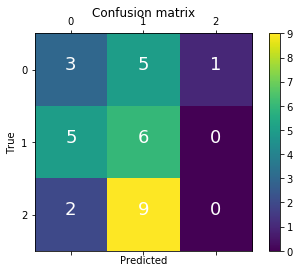

In [108]:
num_epochs = 500
model = LSTM(3).cuda()
model.apply(Network_Initialization)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def accuracy(yinit_v1, lbl_v1):
    return (torch.max(yinit_v1.data, 1)[1].long() == lbl_v1.data).sum().item()

img_v1 = torch.from_numpy(X_vld).float().unsqueeze(1).cuda()
lbl_v1 = torch.from_numpy(y_vld).long().cuda()
model.hidden = model.init_hidden(img_v1.shape[0])
yinit_v1 = model(img_v1)
print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))


preds= torch.max(yinit_v1.data, 1)[1].cpu().numpy()
true = lbl_v1.data.cpu().numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()



In [109]:
mc = 0
train_acc = []
test_acc =  []
acc = 0.0
for epoch in range(num_epochs):
    model.train()
    mc = 0
    for inp, out in data_loader:
        model.zero_grad()
        batch_size = inp.shape[0]
        model.hidden = model.init_hidden(batch_size)
    
        pred = model(inp)
    
        loss = loss_function(pred, out)
        loss.backward()
        
        optimizer.step()
        mc += ((torch.max(pred.data, 1)[1].long() == out.data).sum().item())
        
    if epoch % 10 == 0:
        model.eval()
        model.hidden = model.init_hidden(img_v1.shape[0])
        yinit_v1 = model(img_v1)
        test_acc.append(((accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0]))))
        train_acc.append(mc/float(img.shape[0]))
        print(epoch, loss.item(), mc/float(img.shape[0]), (accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0])))
        
        if((accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0])) > acc ):
            torch.save(model.state_dict(), 'CNN-LSTMModel.pth')
            acc = (accuracy(yinit_v1, lbl_v1)/ float(img_v1.shape[0]))
            print('Model File Saved !')

(0, 1.104374647140503, 0.3218390804597701, 0.2903225806451613)
Model File Saved !
(10, 1.0944123268127441, 0.39080459770114945, 0.22580645161290322)
(20, 1.0703626871109009, 0.4425287356321839, 0.3870967741935484)
Model File Saved !
(30, 1.0723121166229248, 0.47126436781609193, 0.45161290322580644)
Model File Saved !
(40, 1.0704866647720337, 0.5057471264367817, 0.41935483870967744)
(50, 0.967883288860321, 0.5287356321839081, 0.3870967741935484)
(60, 1.001979112625122, 0.5459770114942529, 0.45161290322580644)
(70, 0.926595151424408, 0.5862068965517241, 0.41935483870967744)
(80, 0.813774049282074, 0.6609195402298851, 0.6129032258064516)
Model File Saved !
(90, 0.6414315104484558, 0.6954022988505747, 0.5483870967741935)
(100, 0.7158942222595215, 0.7068965517241379, 0.5483870967741935)
(110, 0.8933200240135193, 0.7241379310344828, 0.6774193548387096)
Model File Saved !
(120, 0.6305855512619019, 0.7701149425287356, 0.6129032258064516)
(130, 0.8133761286735535, 0.7413793103448276, 0.54838709

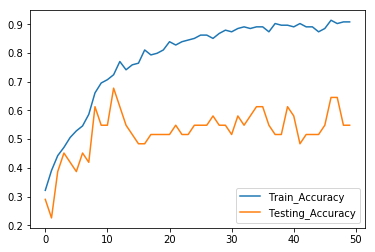

In [110]:
t = np.arange(50)
plt.plot(t, train_acc)
plt.plot(t, test_acc)
plt.legend(['Train_Accuracy', 'Testing_Accuracy'])
plt.show()

In [111]:
model = LSTM(3).cuda()
model.load_state_dict(torch.load('CNN-LSTMModel.pth'))

batch_size = img_v1.shape[0]
model.hidden = model.init_hidden(batch_size)
yinit_v1 = model(img_v1)
print("Testing Accuracy: {0:.2f}".format(accuracy(yinit_v1, lbl_v1) / float(img_v1.shape[0])))

Testing Accuracy: 0.52


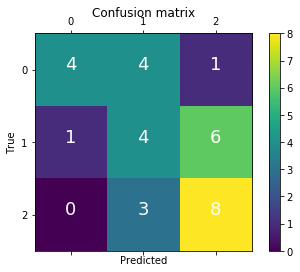

In [112]:
preds= torch.max(yinit_v1.data, 1)[1].cpu().numpy()
true = lbl_v1.data.cpu().numpy()
Conf_Labels = [0,1,2]
conf_matrix = confusion_matrix(true, preds, Conf_Labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + Conf_Labels)
ax.set_yticklabels([''] + Conf_Labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),horizontalalignment="center",color="white", fontsize=18)
plt.show()